In [1]:
import pandas as pd

# URIs for the data
uri_adelie = "https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.219.3&entityid=002f3893385f710df69eeebe893144ff"
uri_gentoo = "https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.220.3&entityid=e03b43c924f226486f2f0ab6709d2381"
uri_chinstrap = "https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-pal.221.2&entityid=fe853aa8f7a59aa84cdd3197619ef462"

# Combine URIs into a list
uris = [uri_adelie, uri_gentoo, uri_chinstrap]

# Download and combine data into a single DataFrame
penguin_raw = pd.concat(
    [pd.read_csv(uri, na_values=["", "NA", "."]) for uri in uris], 
    ignore_index=True
)

# Save the combined DataFrame to a CSV file
penguin_raw.to_csv("penguins_raw.csv", index=False)

# Display the first few rows of the combined DataFrame
penguin_raw.head()


,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


## data cleaning and EDA

In [3]:
#function to do data cleaning
def wrangle (penguin_raw):
    #delete the comments column
    penguin_raw.drop(columns ='Comments', inplace = True)
    #extract date,month, year
    penguin_raw['Date Egg']= pd.to_datetime(penguin_raw['Date Egg'])
    penguin_raw['year'] = penguin_raw['Date Egg'].dt.year
    penguin_raw['month'] = penguin_raw['Date Egg'].dt.month
    penguin_raw['day'] = penguin_raw['Date Egg'].dt.day
    penguin_raw.drop(columns ='Date Egg', inplace = True)
    #delete non informative features
    penguin_raw.drop(columns =['Region','Stage','Individual ID','studyName'], inplace = True)
    penguin_raw.drop(columns = ['Sample Number','year','month', 'Island'], inplace = True)
    #handle missing values
    # Fill missing values with the mean
    penguin_raw['Body Mass (g)'] = penguin_raw['Body Mass (g)'].fillna(penguin_raw['Body Mass (g)'].mean())
    penguin_raw['Culmen Length (mm)'] = penguin_raw['Culmen Length (mm)'].fillna(penguin_raw['Culmen Length (mm)'].mean())
    penguin_raw['Culmen Depth (mm)'] = penguin_raw['Culmen Depth (mm)'].fillna(penguin_raw['Culmen Depth (mm)'].mean())
    penguin_raw['Flipper Length (mm)'] = penguin_raw['Flipper Length (mm)'].fillna(penguin_raw['Flipper Length (mm)'].mean())
    penguin_raw['Delta 15 N (o/oo)'] = penguin_raw['Delta 15 N (o/oo)'].fillna(penguin_raw['Delta 15 N (o/oo)'].mean())
    penguin_raw['Delta 13 C (o/oo)'] = penguin_raw['Delta 13 C (o/oo)'].fillna(penguin_raw['Delta 13 C (o/oo)'].mean())
    #fill missing values 
    #we are using mode because the proportin of male is close to female
    mode_value = penguin_raw['Sex'].mode()[0]
    penguin_raw['Sex'].fillna(mode_value, inplace=True)
    #drop features that are not contributing to the model basing on correlation, feature importance $ coefficients
    #penguin_raw.drop(columns =['Sex','year','month'], inplace = True)
    
    return penguin_raw

In [4]:
df = wrangle(penguin_raw)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              344 non-null    object 
 1   Clutch Completion    344 non-null    object 
 2   Culmen Length (mm)   344 non-null    float64
 3   Culmen Depth (mm)    344 non-null    float64
 4   Flipper Length (mm)  344 non-null    float64
 5   Body Mass (g)        344 non-null    float64
 6   Sex                  344 non-null    object 
 7   Delta 15 N (o/oo)    344 non-null    float64
 8   Delta 13 C (o/oo)    344 non-null    float64
 9   day                  344 non-null    int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 25.7+ KB


In [5]:
#summary statistics for numerical variables
df_numerical = df[df.select_dtypes(include= ['float64','int32']).columns]
print(df_numerical.skew())
df_numerical.describe()

Culmen Length (mm)     0.053272
Culmen Depth (mm)     -0.143880
Flipper Length (mm)    0.346682
Body Mass (g)          0.471690
Delta 15 N (o/oo)      0.243952
Delta 13 C (o/oo)      0.344291
day                    0.003875
dtype: float64


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),day
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,8.733382,-25.686292,15.645349
std,5.443643,1.969027,14.020657,799.613058,0.540392,0.778770,7.924338
min,32.100000,13.100000,172.000000,2700.000000,7.632200,-27.018540,1.000000
25%,39.275000,15.600000,190.000000,3550.000000,8.307415,-26.285460,9.000000
50%,44.250000,17.300000,197.000000,4050.000000,8.687455,-25.793660,16.000000
75%,48.500000,18.700000,213.000000,4750.000000,9.136170,-25.089467,22.000000
max,59.600000,21.500000,231.000000,6300.000000,10.025440,-23.787670,30.000000


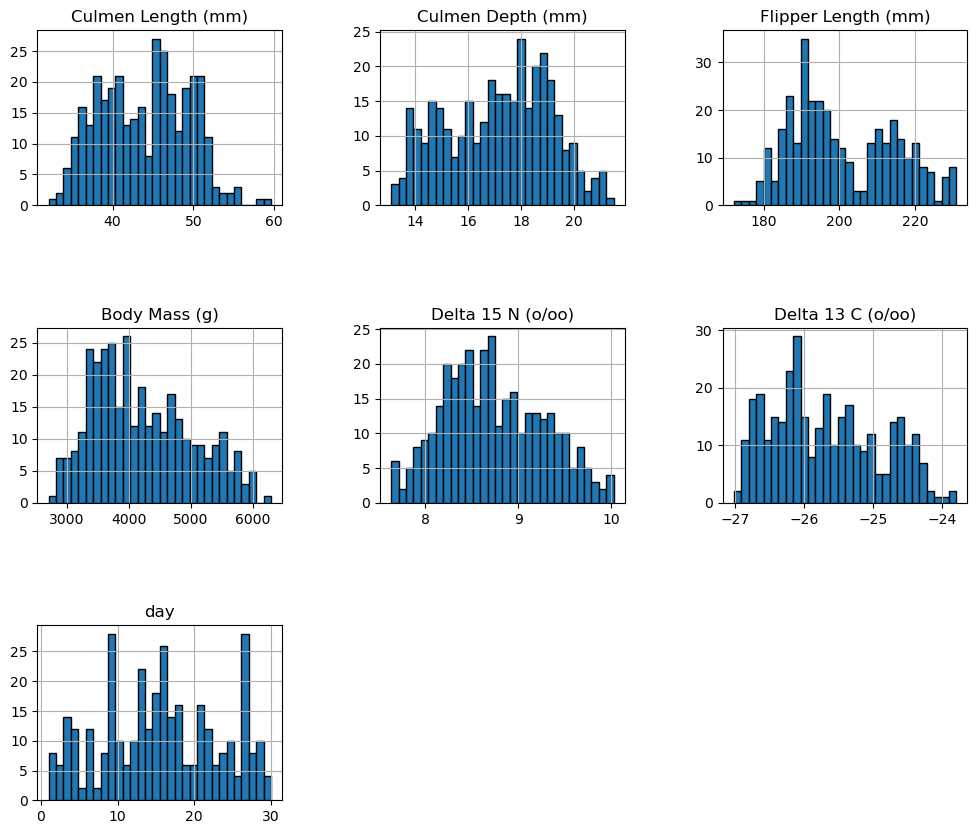

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#create histograms to understand data distribution
df_numerical.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [7]:
# correlation matrix
df_numerical.corr().round(2)

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),day
Culmen Length (mm),1.00,-0.24,0.66,0.60,-0.06,0.19,0.30
Culmen Depth (mm),-0.24,1.00,-0.58,-0.47,0.60,0.42,0.06
Flipper Length (mm),0.66,-0.58,1.00,0.87,-0.50,-0.37,0.03
Body Mass (g),0.60,-0.47,0.87,1.00,-0.53,-0.37,-0.07
Delta 15 N (o/oo),-0.06,0.60,-0.50,-0.53,1.00,0.57,0.16
Delta 13 C (o/oo),0.19,0.42,-0.37,-0.37,0.57,1.00,0.55
day,0.30,0.06,0.03,-0.07,0.16,0.55,1.00


## model building

In [9]:
#import libraries
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

In [10]:
#select target &predictors
y = df['Body Mass (g)']
X = df.drop(columns= 'Body Mass (g)', axis =1)

# Select the numerical/categorical columns
numerical_cols = X.select_dtypes(include= ['float64','int64']).columns
categorical_cols = X.select_dtypes(include= ['object']).columns

# Numerical pipeline
numerical_transformer = Pipeline([('scaler',StandardScaler())])
#categorical pipeline
categorical_transformer = Pipeline([('encoder',OneHotEncoder(drop='first', handle_unknown='ignore'))
                                     ])
#combine 
preprocessor =  ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

X_preprocessed = preprocessor.fit_transform(X)

In [11]:
X_preprocessed.shape

(344, 9)

In [19]:
X.shape

(344, 9)

In [21]:
#traintest split
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape

(275, 9)

## model selection

In [68]:
#baseline
y_pred_baseline = [y.mean()]*len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline,y_train)
mae_baseline

673.6816381128775

In [35]:
#linear regression
from sklearn.model_selection import cross_val_score
model = LinearRegression()
#model evaluation using train data
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('estimator',LinearRegression())
                 ])
complete_pipeline.fit(X_train, y_train)
score = complete_pipeline.score(X_train, y_train)
print('Rsquared on training data:',score)
y_pred_training = complete_pipeline.predict(X_train)
print('Mean absolute error on training data:',mean_absolute_error(y_pred_training,y_train))
scores = cross_val_score(complete_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f"negRMSE for linear regression:{scores.mean()}")

Rsquared on training data: 0.8590550811835856
Mean absolute error on training data: 235.18253530149306
negRMSE for linear regression:-308.5281957276497


In [37]:
#random forest
from sklearn.model_selection import cross_val_score
model = RandomForestRegressor(n_estimators = 100)
#model evaluation using train data
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('estimator',RandomForestRegressor(n_estimators = 100))
                 ])
complete_pipeline.fit(X_train, y_train)
score = complete_pipeline.score(X_train, y_train)
print('Rsquared on training data:',score)
y_pred_training = complete_pipeline.predict(X_train)
print('Mean absolute error on training data:',mean_absolute_error(y_pred_training,y_train))
scores = cross_val_score(complete_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f"negRMSE for random forest regressor:{scores.mean()}")

Rsquared on training data: 0.9783138890709658
Mean absolute error on training data: 91.49331738436997
negRMSE for random forest regressor:-319.2257902531335


In [39]:
#gradient boosting
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=100)
#model evaluation using train data
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('estimator',GradientBoostingRegressor(n_estimators=100))
                 ])
complete_pipeline.fit(X_train, y_train)
score = complete_pipeline.score(X_train, y_train)
print('Rsquared on training data:',score)
y_pred_training = complete_pipeline.predict(X_train)
print('Mean absolute error on training data:',mean_absolute_error(y_pred_training,y_train))
scores = cross_val_score(complete_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f"negRMSE for gradient boosting:{scores.mean()}")

Rsquared on training data: 0.9591946434563099
Mean absolute error on training data: 124.52647879591093
negRMSE for gradient boosting:-319.2239542312207


In [41]:
#ridge
model = Ridge(alpha =0.1)
#model evaluation using train data
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('estimator',Ridge(alpha =0.1))
                 ])
complete_pipeline.fit(X_train, y_train)
score = complete_pipeline.score(X_train, y_train)
print('Rsquared on training data:',score)
y_pred_training = complete_pipeline.predict(X_train)
print('Mean absolute error on training data:',mean_absolute_error(y_pred_training,y_train))
scores = cross_val_score(complete_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f"negRMSE for ridge:{scores.mean()}")

Rsquared on training data: 0.8590493481889305
Mean absolute error on training data: 235.26790216379348
negRMSE for ridge:-308.4660796611499


In [43]:
#XGBOOST
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100)
#model evaluation using train data
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('estimator',XGBRegressor(n_estimators=100))
                 ])
complete_pipeline.fit(X_train, y_train)
score = complete_pipeline.score(X_train, y_train)
print('Rsquared on training data:',score)
y_pred_training = complete_pipeline.predict(X_train)
print('Mean absolute error on training data:',mean_absolute_error(y_pred_training,y_train))
scores = cross_val_score(complete_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f"negRMSE for XGBOOST:{scores.mean()}")

Rsquared on training data: 0.9999974414834757
Mean absolute error on training data: 0.8594522372159091
negRMSE for XGBOOST:-344.64583752828366


## Hyperparameter tuning

In [45]:
import warnings
warnings.filterwarnings("ignore", message="Found unknown categories in columns")

# ridge performed better that the other models
from sklearn.model_selection import GridSearchCV
# Define the Ridge model
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('ridge',Ridge())
                 ])

# Set up the parameter grid for the hyperparameters you want to search
param_grid = {'ridge__alpha':[0.1, 1, 5, 10, 20, 30, 40, 50, 100] }# Regularization strength

# Set up GridSearchCV with Ridge regression model and the parameter grid
grid_search = GridSearchCV(estimator=complete_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose =1)
# fit the grid search 
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters: {'ridge__alpha': 1}
Best Cross-validation Score: -97143.34036681803


## feature importance 

In [47]:
# Fit the entire preprocessor first
preprocessor.fit(X)

# Access the categories_ of OneHotEncoder (if you want to inspect the categories for each column)
print(preprocessor.named_transformers_['cat'].named_steps['encoder'].categories_)

# After transformation, if you want the transformed column names:
# You can get the feature names from the transformed data (this includes the one-hot encoded features)
import pandas as pd

# Apply the preprocessor to the input data and get the transformed features
X_transformed = preprocessor.transform(X)

# Get the column names for the transformed features
column_names = numerical_cols.tolist() + list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols))

# Print the column names of the transformed data
print(column_names)


[array(['Adelie Penguin (Pygoscelis adeliae)',
       'Chinstrap penguin (Pygoscelis antarctica)',
       'Gentoo penguin (Pygoscelis papua)'], dtype=object), array(['No', 'Yes'], dtype=object), array(['FEMALE', 'MALE'], dtype=object)]
['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Species_Chinstrap penguin (Pygoscelis antarctica)', 'Species_Gentoo penguin (Pygoscelis papua)', 'Clutch Completion_Yes', 'Sex_MALE']


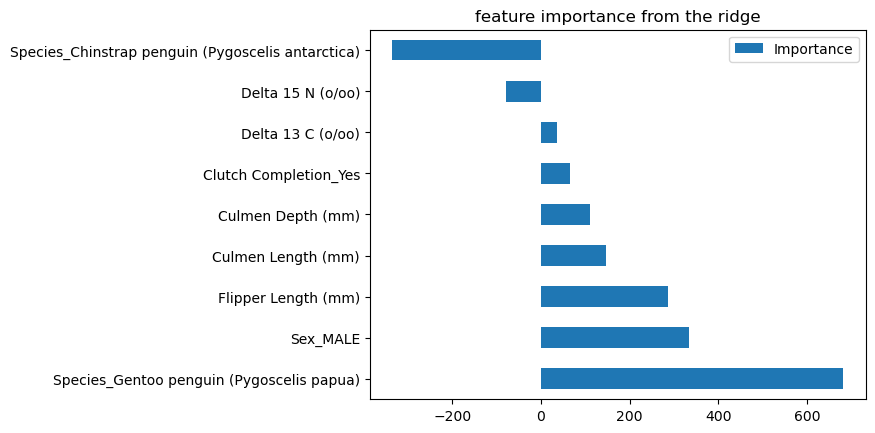

In [49]:
#feature importance from the ridge
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('ridge',Ridge())
                 ])
complete_pipeline.fit(X, y=y)
importance = pd.DataFrame(complete_pipeline.steps[1][1].coef_,
                          index =column_names , 
                          columns = ["Importance"]).sort_values(by= "Importance", ascending= False)
importance.plot(kind = 'barh',title='feature importance from the ridge');

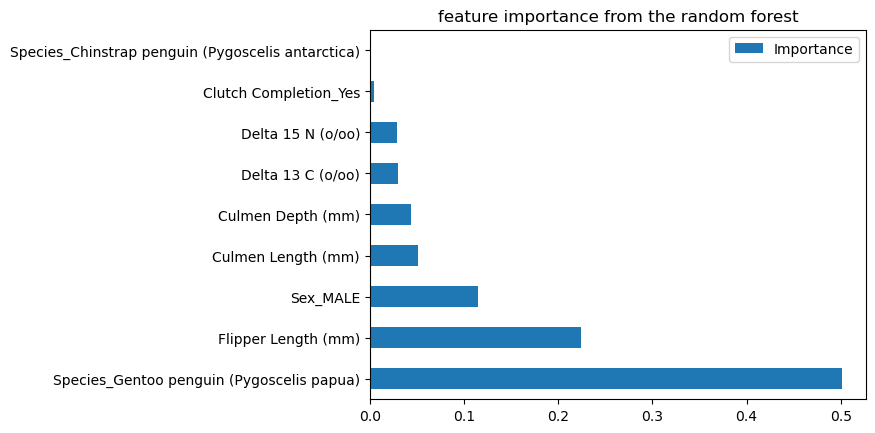

In [51]:
#feature importance from the random forest
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('forest',RandomForestRegressor())
                 ])
complete_pipeline.fit(X, y=y)
importance = pd.DataFrame(complete_pipeline.steps[1][1].feature_importances_,
                          index = column_names, 
                          columns = ["Importance"]).sort_values(by= "Importance", ascending= False)
importance.plot(kind = 'barh', title='feature importance from the random forest');

## model evaluation

In [53]:
#model evaluation using test data
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('estimator',Ridge())
                 ])
complete_pipeline.fit(X_test, y_test)
score = complete_pipeline.score(X_test, y_test)
print('Rsquared on test data for ridge:',score)
y_pred_test = complete_pipeline.predict(X_test)
print('Mean absolute error on test data for ridge:',mean_absolute_error(y_pred_test,y_test))

Rsquared on test data for ridge: 0.9156811278015655
Mean absolute error on test data for ridge: 187.25711727485643


In [55]:
#model evaluation using train data
complete_pipeline = Pipeline([('preprocessor',preprocessor),
                 ('estimator',LinearRegression())
                 ])
complete_pipeline.fit(X_test, y_test)
score = complete_pipeline.score(X_test, y_test)
print('Rsquared on training data:',score)
y_pred_test = complete_pipeline.predict(X_test)
print('Mean absolute error on training data:',mean_absolute_error(y_pred_test,y_test))

Rsquared on training data: 0.9195160762442228
Mean absolute error on training data: 186.48302009730241


## the model is performing better on test data which could signify issues